# **Workshop 07 - Recurrent Neural Networks**

### Facultad de Ingeniería y Ciencias Aplicadas
## *Artificial Intelligence 2020-20*
#### **Professor**: Carla Vairetti
#### **Assistants**: Ignacio Figueroa - María Pía Sánchez

## Text Generation Model


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c03_nlp_constructing_text_generation_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c03_nlp_constructing_text_generation_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Using most of the techniques you've already learned, it's now possible to generate new text by predicting the next word that follows a given seed word. To practice this method, we'll use the [Kaggle Song Lyrics Dataset](https://www.kaggle.com/mousehead/songlyrics).

### Import TensorFlow and related functions

In [15]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import numpy as np
import pandas as pd

### Get the Dataset

As noted above, we'll utilize the [Song Lyrics dataset](https://www.kaggle.com/mousehead/songlyrics) on Kaggle.

In [16]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2020-11-04 22:14:17--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 74.125.20.101, 74.125.20.113, 74.125.20.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.20.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bjsq0jlm3us9240brbgcnj51qdctc8g3/1604528025000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2020-11-04 22:14:20--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bjsq0jlm3us9240brbgcnj51qdctc8g3/1604528025000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)|74.125.195

### **First 10 Songs**

Let's first look at just 10 songs from the dataset, and see how things perform.

### Preprocessing

Let's perform some basic preprocessing to get rid of punctuation and make everything lowercase. We'll then split the lyrics up by line and tokenize the lyrics.

In [17]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [18]:
# Read the dataset from csv - just first 10 songs for now
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:200]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus)

total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)
print(corpus)

{'the': 1, 'i': 2, 'you': 3, 'a': 4, 'and': 5, 'to': 6, 'me': 7, 'it': 8, 'in': 9, 'my': 10, 'of': 11, 'that': 12, 'your': 13, 'im': 14, 'for': 15, 'so': 16, 'is': 17, 'on': 18, 'all': 19, 'love': 20, 'be': 21, 'we': 22, 'la': 23, 'youre': 24, 'dont': 25, 'but': 26, 'like': 27, 'its': 28, 'know': 29, 'when': 30, 'now': 31, 'have': 32, 'no': 33, 'do': 34, 'what': 35, 'can': 36, 'with': 37, 'just': 38, 'was': 39, 'if': 40, 'one': 41, 'see': 42, 'got': 43, 'go': 44, 'time': 45, 'never': 46, 'baby': 47, 'up': 48, 'get': 49, 'were': 50, 'out': 51, 'gonna': 52, 'down': 53, 'this': 54, 'take': 55, 'oh': 56, 'she': 57, 'make': 58, 'want': 59, 'at': 60, 'way': 61, 'yeah': 62, 'well': 63, 'let': 64, 'will': 65, 'think': 66, 'as': 67, 'how': 68, 'feel': 69, 'they': 70, 'are': 71, 'from': 72, 'could': 73, 'cause': 74, 'he': 75, 'cant': 76, 'more': 77, 'girl': 78, 'away': 79, 'honey': 80, 'our': 81, 'day': 82, 'night': 83, 'tell': 84, 'said': 85, 'life': 86, 'gotta': 87, 'say': 88, 'her': 89, 'ther

In [19]:
dataset

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,look at her face its a wonderful face \nand i...
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,take it easy with me please \ntouch me gently...
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,ill never know why i had to go \nwhy i had to...
3,ABBA,Bang,/a/abba/bang_20598415.html,making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,making somebody happy is a question of give an...
...,...,...,...,...
195,Aerosmith,Same Old Song And Dance,/a/aerosmith/same+old+song+dance_20004140.html,get yourself cooler lay yourself low \ncoinci...
196,Aerosmith,Scream In Pain,/a/aerosmith/scream+in+pain_20004499.html,its deep insignus \nthat knows me well \nits...
197,Aerosmith,Seasons Of Wither,/a/aerosmith/seasons+of+wither_20004416.html,blues hearted lady sleepy was she \nlove for ...
198,Aerosmith,Sedona Sunrise,/a/aerosmith/sedona+sunrise+pump+demo_20185659...,i was a city boy \ncaught up in a city way \...


### Create Sequences and Labels

After preprocessing, we next need to create sequences and labels. Creating the sequences themselves is similar to before with `texts_to_sequences`, but also including the use of [N-Grams](https://towardsdatascience.com/introduction-to-language-models-n-gram-e323081503d9); creating the labels will now utilize those sequences as well as utilize one-hot encoding over all potential output words.

In [20]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [21]:
# Check out how some of our data is being stored
# The Tokenizer has just a single index per word
print(tokenizer.word_index['know'])
print(tokenizer.word_index['feeling'])
# Input sequences will have multiple indexes
print(input_sequences[5])
print(input_sequences[6])
# And the one hot labels will be as long as the full spread of tokenized words
print(one_hot_labels[5])
print(one_hot_labels[6])

29
155
[  0   0   0   0   0   0   0   0   0   0   0   0   0 108  60  89 198  28
   4]
[   0    0    0    0    0    0    0    0    0    0    0    0  108   60
   89  198   28    4 1051]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


### Train a Text Generation Model

Building an RNN to train our text generation model will be very similar to the sentiment models you've built previously. The only real change necessary is to make sure to use Categorical instead of Binary Cross Entropy as the loss function - we could use Binary before since the sentiment was only 0 or 1, but now there are hundreds of categories.

From there, we should also consider using *more* epochs than before, as text generation can take a little longer to converge than sentiment analysis, *and* we aren't working with all that much data yet. I'll set it at 200 epochs here since we're only use part of the dataset, and training will tail off quite a bit over that many epochs.

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 128, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


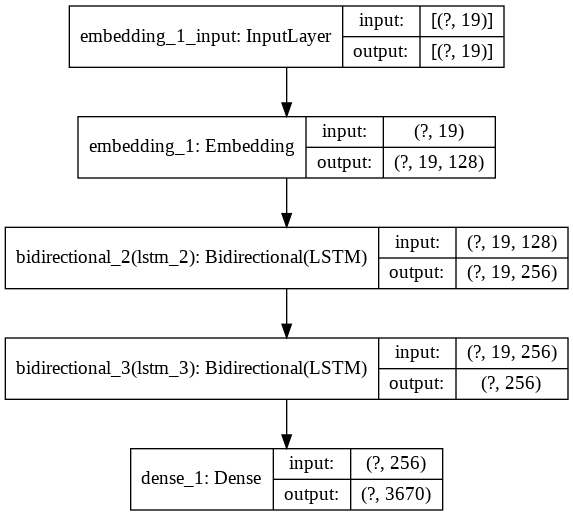

In [23]:
from keras.utils import plot_model
plot_model(model, to_file='/tmp/model.png', show_shapes=True,)

In [24]:
history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1270/1270 [==============================] - 18s 14ms/step - loss: 6.1668 - accuracy: 0.0472
Epoch 2/100
1270/1270 [==============================] - 18s 14ms/step - loss: 5.6041 - accuracy: 0.0693
Epoch 3/100
1270/1270 [==============================] - 18s 14ms/step - loss: 5.2326 - accuracy: 0.1040
Epoch 4/100
1270/1270 [==============================] - 17s 14ms/step - loss: 4.9289 - accuracy: 0.1307
Epoch 5/100
1270/1270 [==============================] - 18s 14ms/step - loss: 4.6450 - accuracy: 0.1550
Epoch 6/100
1270/1270 [==============================] - 18s 14ms/step - loss: 4.3782 - accuracy: 0.1792
Epoch 7/100
1270/1270 [==============================] - 17s 14ms/step - loss: 4.1266 - accuracy: 0.2051
Epoch 8/100
1270/1270 [==============================] - 18s 14ms/step - loss: 3.8878 - accuracy: 0.2350
Epoch 9/100
1270/1270 [==============================] - 17s 14ms/step - loss: 3.6527 - accuracy: 0.2632
Epoch 10/100
1270/1270 [==============================]

### View the Training Graph

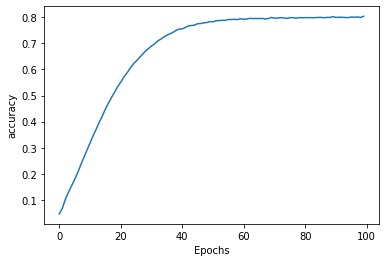

In [25]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

### Generate new lyrics!

It's finally time to generate some new lyrics from the trained model, and see what we get. To do so, we'll provide some "seed text", or an input sequence for the model to start with. We'll also decide just how long of an output sequence we want - this could essentially be infinite, as the input plus the previous output will be continuously fed in for a new output word (at least up to our max sequence length).

In [31]:
seed_text = "fuck you"
next_words = 90
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

fuck you up see you tomorrow bitch sordo redoblar in a dreamworld its a heaven of your tail on a man man in man ive seem a club can calm began to meet it seems to hit my apple to get my life before you face for me now get me as the sun find you hear me she she wouldnt please it cant gave me it aint gonna get it cant fool up just never never dancing more i say im far inside to me gonna day you day the same


## **Project 4**

*Objectives:* create positive and negative reviews from a dataset of reviews from Amazon and Yelp, and then classify them.

To do this, you will first have to create a Text Generator based on the one we gave you in the workshop. You will have to adapt it so that phrases are generated as coherent as possible.
Then you will have to do some research on the recurrent layer GRU, which is very similar to LSTM. You must replace it in the model you created, and then compare the results between before and after.
Finally, based on the Text Classification Model that we're going to see in the Assistantship #10 (October 29), you will classificate the results of the generated reviews.


Steps to follow to do the project:
- Preprocess the data to make it as clean as possible.
- Adapt the Song Generator model:
   * Add more layers, neurons and / or use regularization.
   * Add another LSTM layer to the model. What is the difference between having one layer versus two LSTM layers on the model?
- Adapt the Text Classification model:
   * Add more layers, neurons and / or use regularization.
   * Add another LSTM layer to the model. What is the difference between having one layer versus two LSTM layers on the model?
- Investigate about the GRU layer. What differences does it have with the LSTM layer?
- Replace the GRU layer with LSTM layer. What differences can you see? Which one delivers a better result?

This project is in groups of two members, and you must submit a report containing the following:

1.   **Introduction**
2.   **Data**: Pre-processing (for both models)
3.   **Models** (Generator and classifier): briefly define each layer to be used and its function within the model, justify each element added / removed within the delivered models.
4.   **Results** (of each model): describe each of the results obtained.
5.   **Discussion**: analyze the results obtained. Guide yourself with questions given in the steps.
6.   **Conclusion**

The report should not contain more than 12 pages.
Delivery: 05/11/2020 23:59 hrs.

### Dataset Amazon and Yelp Reviews

In [27]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P -O /tmp/sentiment.csv

--2020-11-04 22:44:43--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 74.125.142.101, 74.125.142.138, 74.125.142.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nhpvr4qh736fm9klds5ebcqk9nck2782/1604529825000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2020-11-04 22:44:44--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nhpvr4qh736fm9klds5ebcqk9nck2782/1604529825000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|74.125